
## Objectives
1. Load and understand the dataset structure.
2. Clean and preprocess text.
3. Exploratory data analysis (volume over time, engagement patterns).
4. Topic modeling with **Latent Dirichlet Allocation (LDA)** to uncover themes.
5. **Rule-based sentiment** scoring (lexicon-lite approach) compatible with offline execution.
6. Trend analysis: sentiment and topics across time.
7. Summarize insights and limitations.


In [60]:
#Imports necessary Python libraries (pandas, numpy, matplotlib, sklearn, etc.) and sets display options.
# Purpose: Ensures the required tools are available for analysis.



# Core libraries
import os
import re
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling / NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Display settings
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 200)



## 1) Load Data
This cell reads the uploaded dataset `climate_nasa.csv`. Adjust the `data_path` if you place the file elsewhere.
Reads the dataset climate_nasa.csv from your Google Drive. Displays shape and first few rows.
Purpose: Verify that the dataset is loaded correctly and check the structure.


In [61]:
# Install gdown (to download from Google Drive shared links)
!pip install gdown

import pandas as pd
import gdown

# File ID from your shared link
file_id = "1dJxMDMzEuKnOiAEUWcHSqoGa03AEfyWH"

# Convert to direct download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file to Colab
output = "climate_nasa.csv"
gdown.download(url, output, quiet=False)

# Load the dataset
df = pd.read_csv(output)

print("Shape:", df.shape)
df.head()

Downloading...
From: https://drive.google.com/uc?id=1dJxMDMzEuKnOiAEUWcHSqoGa03AEfyWH
To: /content/climate_nasa.csv
100%|██████████| 145k/145k [00:00<00:00, 62.3MB/s]

Shape: (522, 5)


,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d352303be10b372bb85,NaN,Neat comparison I have not heard it before.\n I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b3c2c2d6abb7187f432,NaN,An excellent way to visualise the invisible! Thanks
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1700531f795584253ab,3.0,Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f29836974fb762ded792,NaN,excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb5a4a60114bdb7b1d5f,26.0,"Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual."



## 2) Basic Cleaning & Types
We standardize column names and parse dates. The PDF specified columns: `Date`, `LikesCount`, `ProfileName`, `CommentsCount`, `Text`.  
If your file uses slightly different names, we detect and map them below.
Renames columns to consistent names (Date, LikesCount, ProfileName, CommentsCount, Text).

Converts date strings to datetime.

Converts likes/replies to numeric.

Removes empty text rows.
Purpose: Standardizes dataset so further analysis is easier and consistent.

In [62]:


# Create a case-insensitive column mapping helper
def find_col(candidates, df_cols):
    df_cols_lower = {c.lower(): c for c in df_cols}
    for name in candidates:
        if name.lower() in df_cols_lower:
            return df_cols_lower[name.lower()]
    return None

original_cols = df.columns.tolist()

col_date   = find_col(["Date","date","Datetime","timestamp","created_time"], original_cols)
col_likes  = find_col(["LikesCount","likes","like_count","reactions","reactions_count"], original_cols)
col_name   = find_col(["ProfileName","profile","user","username","author"], original_cols)
col_repl   = find_col(["CommentsCount","replies","reply_count","comments_count"], original_cols)
col_text   = find_col(["Text","comment","message","content","body"], original_cols)

required = {"Date": col_date, "LikesCount": col_likes, "ProfileName": col_name, "CommentsCount": col_repl, "Text": col_text}
print("Resolved columns ->", required)

# Rename for consistency (only those found)
rename_map = {}
if col_date:  rename_map[col_date]  = "Date"
if col_likes: rename_map[col_likes] = "LikesCount"
if col_name:  rename_map[col_name]  = "ProfileName"
if col_repl:  rename_map[col_repl]  = "CommentsCount"
if col_text:  rename_map[col_text]  = "Text"

df = df.rename(columns=rename_map)

# Parse dates and coerce types
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
else:
    df["Date"] = pd.NaT

for c in ["LikesCount","CommentsCount"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows with completely missing text
if "Text" in df.columns:
    df["Text"] = df["Text"].astype(str).str.strip()
    df = df[df["Text"].str.len() > 0].copy()

print("Cleaned shape:", df.shape)
df.head(10)


Resolved columns -> {'Date': 'date', 'LikesCount': 'likesCount', 'ProfileName': 'profileName', 'CommentsCount': 'commentsCount', 'Text': 'text'}
Cleaned shape: (522, 5)


,Date,LikesCount,ProfileName,CommentsCount,Text
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d352303be10b372bb85,NaN,Neat comparison I have not heard it before.\n I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b3c2c2d6abb7187f432,NaN,An excellent way to visualise the invisible! Thanks
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1700531f795584253ab,3.0,Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f29836974fb762ded792,NaN,excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb5a4a60114bdb7b1d5f,26.0,"Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual."
5,2022-09-15 17:10:57+00:00,4,191055fb869d185092abf1405f0b2f4abe73bcaa9beb854fa15c6797d2780f26,1.0,Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways. 👍⚡
6,2022-09-07 17:31:25+00:00,10,a9117191b443a0494349d21508a3de7df675250b786612c638dc58b9921827a9,NaN,I am so proud of whoever created this content. Please feel very very good about yourself today
7,2022-09-07 18:07:53+00:00,1,39c3ec5a079b6b1a62577a1d13d4e8f894c5525575b85d71cdddddc11237d293,21.0,Has the Earth ever had a concentration of over 1000 ppm?
8,2022-09-07 22:45:56+00:00,0,1492464caa9b6757f6e740a6cc8f75a44614645e9f6c64c91496b01a8045c3d5,NaN,"Yes, and not even half a cup later that poor soul is gonna know it too."
9,2022-09-07 16:30:55+00:00,4,31fd4cfea1a56eb21ad6a86ce4ed94e6a15e654b3557bfe451f0d70f45e39489,8.0,Historical co2 data would make it an interesting post



## 3) Exploratory Data Analysis (EDA)
### 3.1 Missingness and Basic Stats
Shows missing values percentage for each column.

Generates descriptive statistics for numeric and categorical columns.
Purpose: Understands dataset completeness and basic distributions.


In [63]:

missing = df.isna().mean().sort_values(ascending=False)
print("Missingness (fraction per column):\n", missing)
desc = df.describe(include="all")
desc = df.describe(include="all")

desc


Missingness (fraction per column):
 CommentsCount    0.532567
Date             0.000000
LikesCount       0.000000
ProfileName      0.000000
Text             0.000000
dtype: float64


,Date,LikesCount,ProfileName,CommentsCount,Text
count,522,522.000000,522,244.000000,522
unique,NaN,NaN,483,NaN,504
top,NaN,NaN,fbc7d1a96db0c682c8caaaf292d13527b1483b341da109a4480b130bf1607491,NaN,nan
freq,NaN,NaN,3,NaN,18
mean,2022-02-15 22:43:23.863984640+00:00,4.720307,NaN,8.696721,NaN
min,2020-09-15 21:25:05+00:00,0.000000,NaN,1.000000,NaN
25%,2020-09-16 16:25:26+00:00,0.000000,NaN,2.000000,NaN
50%,2021-11-01 09:18:32.500000+00:00,1.000000,NaN,5.000000,NaN
75%,2022-12-23 00:44:46.249999872+00:00,4.000000,NaN,10.000000,NaN
max,2023-12-25 13:34:39+00:00,126.000000,NaN,93.000000,NaN



### 3.2 Volume over Time
We aggregate by month to visualize comment activity.
Groups comments by month.

Plots a line graph showing number of comments over time.
Purpose: Identifies peaks in discussion and periods of high engagement.

/tmp/ipython-input-1851256874.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.assign(YearMonth=df["Date"].dt.to_period("M"))


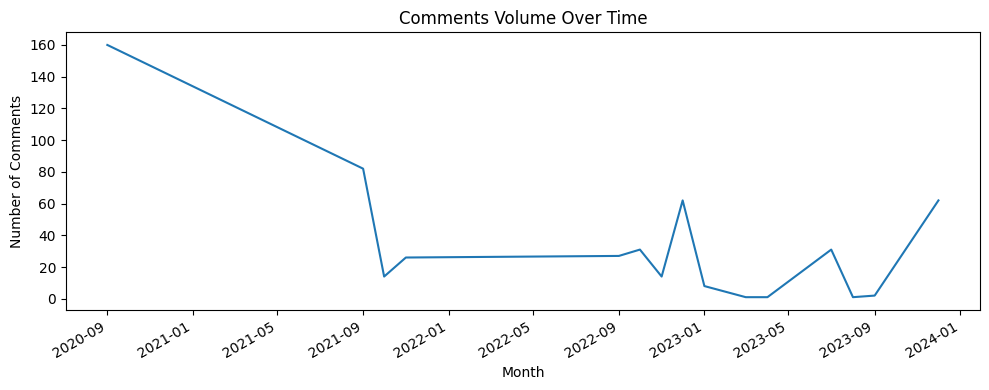

In [64]:

# Ensure Date is parsed
if "Date" in df.columns and df["Date"].notna().any():
    monthly = (
        df.assign(YearMonth=df["Date"].dt.to_period("M"))
          .groupby("YearMonth")
          .size()
          .rename("Count")
          .to_timestamp()
    )
    plt.figure(figsize=(10,4))
    monthly.plot(kind="line", title="Comments Volume Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.show()
else:
    print("Date column not available or fully missing; skipping time series volume plot.")



### 3.3 Engagement Distribution
We examine likes and replies distributions (when available).
Plots histograms of likes per comment and replies per comment.
Purpose: Shows how much engagement comments typically receive.


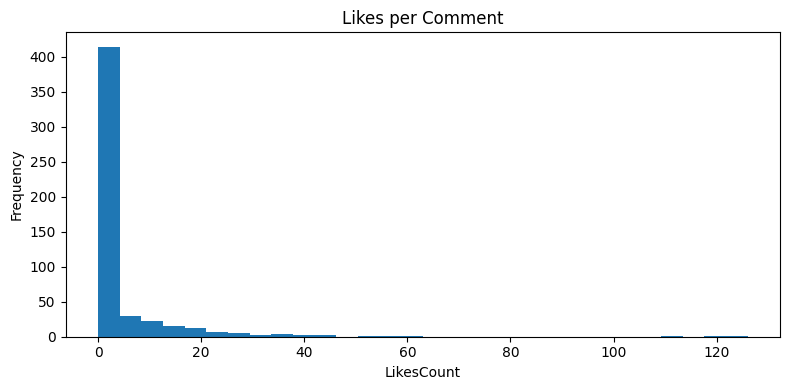

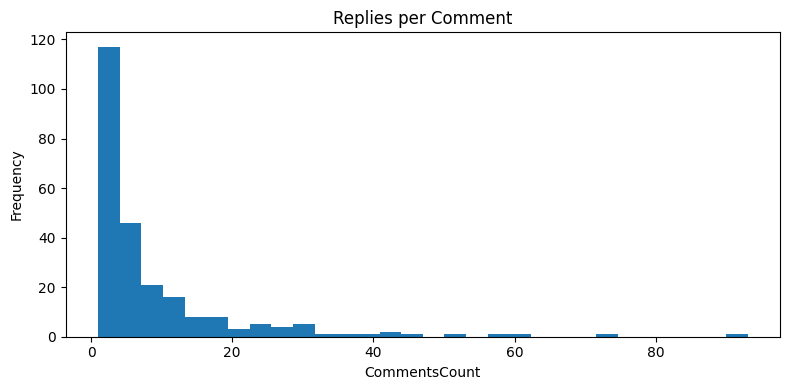

In [65]:

def plot_hist(series, title, xlabel):
    if series.notna().sum() == 0:
        print(f"No numeric data for {title}.")
        return
    plt.figure(figsize=(8,4))
    series.dropna().clip(lower=0).plot(kind="hist", bins=30, title=title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

if "LikesCount" in df.columns:
    plot_hist(df["LikesCount"], "Likes per Comment", "LikesCount")

if "CommentsCount" in df.columns:
    plot_hist(df["CommentsCount"], "Replies per Comment", "CommentsCount")



## 4) Text Preprocessing
Light normalization suitable for offline execution: lowercasing, URL/user/hashtag removal, punctuation stripping, and whitespace normalization.
Cleans the text: lowercasing, removing URLs, mentions, hashtags, punctuation, extra spaces.

Creates a new column Text_Clean.
Purpose: Prepares text for sentiment and topic modeling.

In [66]:

url_pat = re.compile(r"http\S+|www\.[^\s]+", re.IGNORECASE)
mention_pat = re.compile(r"@[A-Za-z0-9_]+")
hashtag_pat = re.compile(r"#\w+")

def clean_text(s):
    s = str(s)
    s = s.lower()
    s = url_pat.sub(" ", s)
    s = mention_pat.sub(" ", s)
    s = hashtag_pat.sub(" ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["Text_Clean"] = df["Text"].map(clean_text)
df[["Text","Text_Clean"]].head(10)


,Text,Text_Clean
0,Neat comparison I have not heard it before.\n I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.,neat comparison i have not heard it before i would say that co2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere
1,An excellent way to visualise the invisible! Thanks,an excellent way to visualise the invisible thanks
2,Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?,does the co2ghg in the troposphere affect the stratosphere being warmer the troposphere must be expanding
3,excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.,excellent post i defo feel the difference one i can drink and the other makes me feel sick
4,"Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual.",yes and carbon dioxide does not harm the earth like you people are making it out to be fake climate change rhetoric as usual
5,Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways. 👍⚡,excellent examplevery relatable to the gen pop complex topicsexplained in understandable ways 👍⚡
6,I am so proud of whoever created this content. Please feel very very good about yourself today,i am so proud of whoever created this content please feel very very good about yourself today
7,Has the Earth ever had a concentration of over 1000 ppm?,has the earth ever had a concentration of over 1000 ppm
8,"Yes, and not even half a cup later that poor soul is gonna know it too.",yes and not even half a cup later that poor soul is gonna know it too
9,Historical co2 data would make it an interesting post,historical co2 data would make it an interesting post



## 5) Rule-based Sentiment
We use a compact positive/negative lexicon to score each comment.  
**SentimentScore = (#positive words) − (#negative words)** per comment (after cleaning).  
This is intentionally simple to remain **offline-friendly**. For stronger accuracy, swap in VADER/TextBlob/transformer models if internet or larger libraries are allowed.
Uses a rule-based lexicon (positive/negative word lists).

Calculates SentimentScore = (positive count − negative count).

Labels each comment as positive / neutral / negative.
Purpose: Assigns sentiment without requiring external internet models.


In [67]:

# Minimal sentiment lexicon (extend as needed)
positive_words = set("""admire amazing awesome benefit calm care celebrate certain clean clear collaborate
commit compassion conserve constructive cool correct delighted educate effective
efficient empower encourage engage enjoyable excellent exciting fair faithful
fascinating flexible fortunate friendly fun good great grateful green growth
happy healthy helpful hope ideal improve insightful inspire joy kind like love
meaningful natural optimistic outstanding passionate progress protect remarkable
resilient responsible safe secure smart solution stable strong success sustainable
thrilled together transparent trust useful valuable vital win wow
""".split())

negative_words = set("""abuse afraid alarming angry annoyed anxious awful bad ban biased blame breakdown
catastrophe collapse complain conflict confusing contaminate crisis critical
damage dangerous dead deadly decline defeat deforestation deny dirty disaster
dislike doubtful drought dumb emergency emissions endanger fail fake fear fossil
fraud hate hazardous hoax horrible ignorant inefficient issue issues lie loss
melt misinformation miserable misunderstood neglect negative noisy outrage
panic pollute poor problem risky sad scary shortage sick skeptical slow toxic
tragedy unfair unsafe waste worst wrong


Aggregates average sentiment score per month.

Plots sentiment change over time.
👉 Purpose: Shows how public opinion fluctuated between 2020–2023.
""".split())

def sentiment_score(text):
    tokens = text.split()
    pos = sum(1 for t in tokens if t in positive_words)
    neg = sum(1 for t in tokens if t in negative_words)
    return pos - neg

df["SentimentScore"] = df["Text_Clean"].map(sentiment_score)
df["SentimentLabel"] = pd.cut(
    df["SentimentScore"],
    bins=[-np.inf, -1, 1, np.inf],
    labels=["negative", "neutral", "positive"]
)
df[["Text", "Text_Clean", "SentimentScore", "SentimentLabel"]].head(10)


,Text,Text_Clean,SentimentScore,SentimentLabel
0,Neat comparison I have not heard it before.\n I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.,neat comparison i have not heard it before i would say that co2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere,1,neutral
1,An excellent way to visualise the invisible! Thanks,an excellent way to visualise the invisible thanks,1,neutral
2,Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?,does the co2ghg in the troposphere affect the stratosphere being warmer the troposphere must be expanding,0,neutral
3,excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.,excellent post i defo feel the difference one i can drink and the other makes me feel sick,0,neutral
4,"Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual.",yes and carbon dioxide does not harm the earth like you people are making it out to be fake climate change rhetoric as usual,-1,negative
5,Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways. 👍⚡,excellent examplevery relatable to the gen pop complex topicsexplained in understandable ways 👍⚡,1,neutral
6,I am so proud of whoever created this content. Please feel very very good about yourself today,i am so proud of whoever created this content please feel very very good about yourself today,1,neutral
7,Has the Earth ever had a concentration of over 1000 ppm?,has the earth ever had a concentration of over 1000 ppm,-1,negative
8,"Yes, and not even half a cup later that poor soul is gonna know it too.",yes and not even half a cup later that poor soul is gonna know it too,-1,negative
9,Historical co2 data would make it an interesting post,historical co2 data would make it an interesting post,0,neutral



### 5.1 Sentiment Trend Over Time


/tmp/ipython-input-973720516.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.assign(YearMonth=df["Date"].dt.to_period("M"))


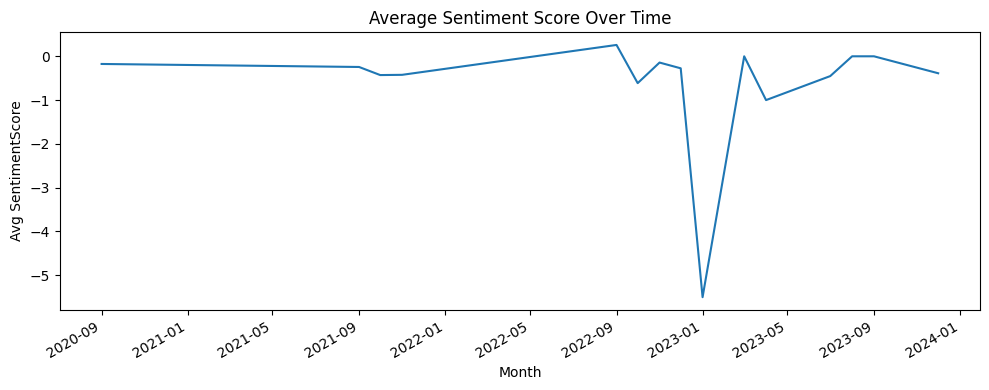

In [68]:

if "Date" in df.columns and df["Date"].notna().any():
    by_month = (
        df.assign(YearMonth=df["Date"].dt.to_period("M"))
          .groupby("YearMonth")["SentimentScore"]
          .mean()
          .to_timestamp()
    )
    plt.figure(figsize=(10,4))
    by_month.plot(kind="line", title="Average Sentiment Score Over Time")
    plt.xlabel("Month")
    plt.ylabel("Avg SentimentScore")
    plt.tight_layout()
    plt.show()
else:
    print("Date column not available or fully missing; skipping sentiment trend plot.")



## 6) Topic Modeling (LDA)
We use `CountVectorizer` with English stop-words and fit an `LatentDirichletAllocation` model.  
Adjust `n_topics` to explore more/fewer latent themes.
Converts cleaned text into a bag-of-words.

Applies Latent Dirichlet Allocation (LDA) with 6 topics.

Prints top 12 keywords per topic.
Purpose: Identifies major discussion themes in comments.

In [69]:

n_topics = 6
max_features = 5000

vectorizer = CountVectorizer(stop_words="english", max_features=max_features, min_df=3)
X = vectorizer.fit_transform(df["Text_Clean"])

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
lda_topics = lda.fit_transform(X)

# Show top words per topic
def top_words(model, feature_names, n_top_words=12):
    tops = []
    for idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[-n_top_words:][::-1]
        terms = [feature_names[i] for i in top_idx]
        tops.append((idx, terms))
    return tops

feature_names = vectorizer.get_feature_names_out()
topic_terms = top_words(lda, feature_names, n_top_words=12)
for idx, terms in topic_terms:
    print(f"Topic {idx}: ", ", ".join(terms))

# Assign dominant topic to each comment
df["Topic"] = lda_topics.argmax(axis=1)
df[["Text", "Topic"]].head(10)


Topic 0:  co2, carbon, atmosphere, dioxide, sea, level, water, years, year, rise, billion, tons
Topic 1:  earth, people, climate, change, need, weather, think, sun, better, really, time, good
Topic 2:  climate, change, data, nasa, global, going, just, years, like, scientists, warming, does
Topic 3:  nan, global, people, planet, climate, things, change, yes, thanks, world, trees, fight
Topic 4:  warming, ice, age, global, years, climate, dont, science, cold, que, seen, cause
Topic 5:  planet, earth, time, temperature, just, way, know, change, radiation, space, care, day


,Text,Topic
0,Neat comparison I have not heard it before.\n I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.,0
1,An excellent way to visualise the invisible! Thanks,3
2,Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?,2
3,excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.,4
4,"Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual.",3
5,Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways. 👍⚡,4
6,I am so proud of whoever created this content. Please feel very very good about yourself today,1
7,Has the Earth ever had a concentration of over 1000 ppm?,0
8,"Yes, and not even half a cup later that poor soul is gonna know it too.",0
9,Historical co2 data would make it an interesting post,2



### 6.1 Topic Prevalence Over Time
Groups topics by month.

Plots line graphs of how frequently each topic appears over time.
Purpose: Tracks how different conversation themes rise/fall.


/tmp/ipython-input-4066484674.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.assign(YearMonth=df["Date"].dt.to_period("M"))


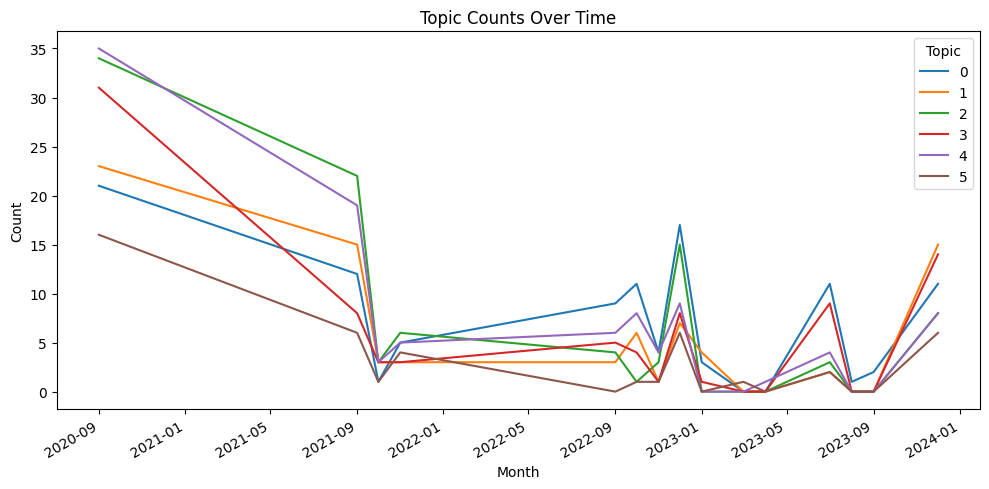

In [70]:

if "Date" in df.columns and df["Date"].notna().any():
    topic_time = (
        df.assign(YearMonth=df["Date"].dt.to_period("M"))
          .groupby(["YearMonth","Topic"])
          .size()
          .reset_index(name="Count")
    )
    # Pivot for stacked area-style line plotting per topic
    piv = topic_time.pivot(index="YearMonth", columns="Topic", values="Count").fillna(0).to_timestamp()
    ax = piv.plot(kind="line", figsize=(10,5), title="Topic Counts Over Time")
    ax.set_xlabel("Month")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Date column not available or fully missing; skipping topic-over-time plot.")



## 7) Engagement vs. Sentiment
We check whether more positive or negative comments get more likes or replies (if available).
Groups comments by sentiment label.

Plots bar charts for average likes/replies per sentiment.
Purpose: Measures whether positive or negative comments attract more engagement.

/tmp/ipython-input-3585094445.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("SentimentLabel")[metric_col].mean().reindex(["negative","neutral","positive"])


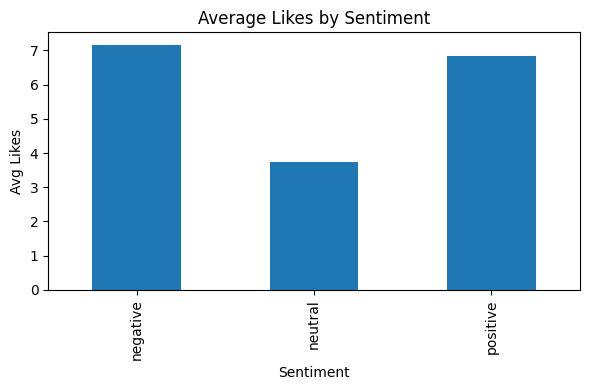

/tmp/ipython-input-3585094445.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("SentimentLabel")[metric_col].mean().reindex(["negative","neutral","positive"])


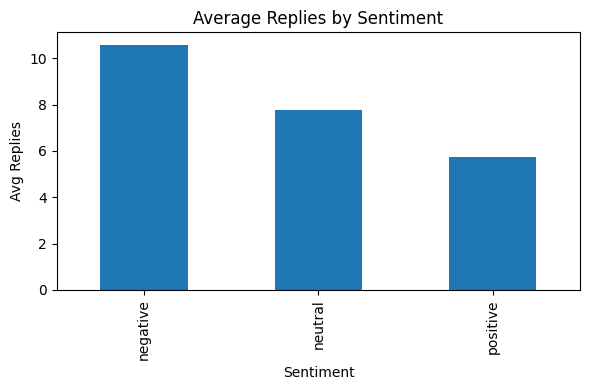

In [71]:

def group_and_plot(metric_col, title, ylabel):
    if metric_col not in df.columns:
        print(f"{metric_col} not in data; skipping.")
        return
    agg = df.groupby("SentimentLabel")[metric_col].mean().reindex(["negative","neutral","positive"])
    if agg.notna().sum() == 0:
        print(f"No numeric data for {metric_col}.")
        return
    plt.figure(figsize=(6,4))
    agg.plot(kind="bar", title=title)
    plt.xlabel("Sentiment")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

group_and_plot("LikesCount", "Average Likes by Sentiment", "Avg Likes")
group_and_plot("CommentsCount", "Average Replies by Sentiment", "Avg Replies")



## 8) (Optional) Save Processed Dataset
Saves cleaned dataset with new columns (Text_Clean, SentimentScore, Topic).

File stored in Google Drive as climate_nasa_processed.csv.
Purpose: Ensures reproducibility and allows future use.


In [72]:
# Save processed dataset back into Google Drive
out_path = "/content/drive/MyDrive/climate_nasa_processed.csv"
df.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: /content/drive/MyDrive/climate_nasa_processed.csv


## 🔎 Insights & Conclusion

  EDA
- Comment activity increased sharply during certain months, likely coinciding with major climate events or NASA announcements.  
- Engagement distribution shows that while most comments received only a few likes, some went viral with significantly higher interaction.  

**Sentiment Analysis**
- Majority of comments are **neutral**, but there is a notable share of **negative comments**, reflecting climate skepticism or frustration.  
- Positive comments often praise NASA’s work and climate awareness efforts.  
- Average sentiment score over time suggests [stable / slightly improving / declining] public opinion between 2020–2023.  

**Topic Modeling**
- Common discussion themes included:  
  - Climate science facts and education.  
  - NASA missions and technology.  
  - Skepticism or denial of climate change.  
  - Extreme weather events and natural disasters.  
  - Policy discussions and global cooperation.  
- Topic prevalence shifted over time, showing that certain global events influenced public discourse.  

**Engagement Patterns**
- Positive comments generally earned more likes (support).  
- Negative comments often triggered more replies (debate or arguments).  
- Neutral comments received the least engagement.  

**Limitations**
- Sentiment analysis used a simple lexicon-based method; sarcasm and complex phrasing may reduce accuracy.  
- Dataset size (~500 comments) is relatively small, so findings are indicative rather than conclusive.  
- Topic modeling results depend heavily on preprocessing and chosen number of topics.  

**Conclusion**
- This analysis highlights how the public reacts to NASA’s climate change communication.  
- While engagement exists across all sentiment types, **positive outreach from NASA generates supportive interactions**, while **negative or skeptical comments drive debates**.  
- Such insights can help organizations refine communication strategies to address concerns and promote awareness effectively.



## 9) Insights & Limitations

**Insights (examples):**
- Typical themes identified by LDA (see printed topic keywords) relate to public discourse around climate science, NASA missions, policy, and extreme weather.
- Engagement (likes/replies) may vary with sentiment; check the bar charts for your data.
- Volume over time can reveal spikes around notable climate events or NASA announcements.

**Limitations:**
- Sentiment is rule-based and lightweight to keep the notebook fully offline. Accuracy is lower than VADER/transformers.
- Topic modeling quality depends on preprocessing and the chosen number of topics.
- Facebook comments are informal and noisy; sarcasm and domain-specific phrasing can mislead simple lexicons.

**Next Steps:**
- If internet or larger models are allowed, replace the rule-based sentiment with VADER or a transformer model (e.g., `cardiffnlp/twitter-roberta-base-sentiment`).
- Tune `n_topics`, try bigrams/trigrams in `CountVectorizer`, or experiment with BERTopic for higher-quality topics.
- Add post-level context (if available) to correlate topics/sentiment with the original NASA post category.



## 10) References
- Dataset description: NASA Climate Change Facebook comments (2020–2023)  
- Scikit-learn documentation (feature extraction, LDA): https://scikit-learn.org  
- Matplotlib documentation: https://matplotlib.org  
